# Stock Trading by Congress Members

Lucas Papaioannou

## Summary of Findings

### Introduction
This dataset is a dataset of stock trading disclosures from members of congress. It includes the tickers of stocks being traded, the date the trade happened, and the congress member that did the trade. The question I am asking is "Do the members of different parties tend to trade in the same stocks?" This dataset relates to this question because of the data within this dataset that I noted above. However, this dataset does not have a column for party membership for the congress members.

### Cleaning and EDA
First, I imported the required transactions dataset and I also imported a dataset from Kaggle that contains the party membership of each congressional district. I then cleaned the data a little by replacing improperly coded missing data which were "--" with np.NaN. I then converted the diclosure_date and transaction_date columns to a timestamp dtype. However, there were some improperly coded date in the transaction_date column so I had to go to source pdfs in those rows and changed the incorrect date to the correct date. I did these conversions as I wanted to prepared in case I wanted to do analysis based on timestamps. I then added congressmembers' party by merging the the other dataset I imported before into the transactions dataset.

After doing some cleaning and merging the party membership data into the transactions dataset I proceeded to do some data analysis. The univariate analysis I did consisted of plotting the number of trades by party, plotting the number of trades by amount, plotting the number of trades by representative, and plotting number of trades by ticker. For the last two plots I only plotted the top 20 for each as there would be too many bars to graph. Some things I noticed that the Democrats have a greater number of trades and the congress member that does the most trades does so by a rather large margin.

My bivariate analysis consisted of plotting the number of trades by party for three big oil stocks XOM, CVX, and BP and plotting the number of amounts per party. I also grouped by party and ticker to preform an aggregate analysis. With these plots and analysis I noticed that Republicans tend to trade more in these three oil stocks and that the different parties tend to invest in very different stocks.

### Assessment of Missingness
I do no believe that there is a column in this dataset that is NMAR. By looking at some of the source pdfs in the dataset most of the missing 'owner' entries are in disclosures where most of the disclosed transactions do have an 'owner' entry. Because of this I cannot claim that the data in this column is NMAR without knowing more about congressional protocols about diclosures. The column in this dataset that has non-trivial missingness is the 'owner' column. I calculated the KS stat for 3 columns : 'representative', 'district', and 'ptr_link'. The p-values for each of the columns were, 0.000237, 0.000309, and 0.000363 respectively. These p-values mean that the missingness of the 'owner' columns depends on the values in the 'representative', 'district', and 'ptr_link' columns.

### Hypothesis Test
My null hypothesis is "The distribution of number of trades by ticker among Republicans is the same as those who are Democrats. The difference between the two observed samples is due to chance."

My alternative hypothesis is "the distribution of number of trades by ticker of these two groups is different."

To test these hypotheses I selected the 2 columns that were pertinent to thes hypotheses: the 'ticker' and 'party' columns.

I then conducted a permuation test with 1000 repititions with Total Variation Distance or TVD as a test statistic. The resulting p-value from this permutation test was 0.0. Because of this extremely low p-value I reject the null hypothesis in favor of the alternative hypothesis that the distribution of number of trades by ticker of these two groups is different.

## Code

In [382]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy import stats

### Cleaning and EDA

The following code block goes through the cleaning, merging, and analysis that is described in the summary. The univariate plots are the number of trades by party, the number of trades by amount, the number of trades by representative, and the number of trades by ticker. The bivariate plots are trades by party for three big oil stocks: XOM, CVX, and BP and plotting the number of amounts per party.

party,democrat,republican
ticker,,
35G.SG,0.0,2.0
7XY,1.0,0.0
A,2.0,1.0
AA,1.0,1.0
AAGIY,4.0,8.0
...,...,...
ZM,13.0,1.0
ZNGA,3.0,0.0
ZOOM,3.0,0.0


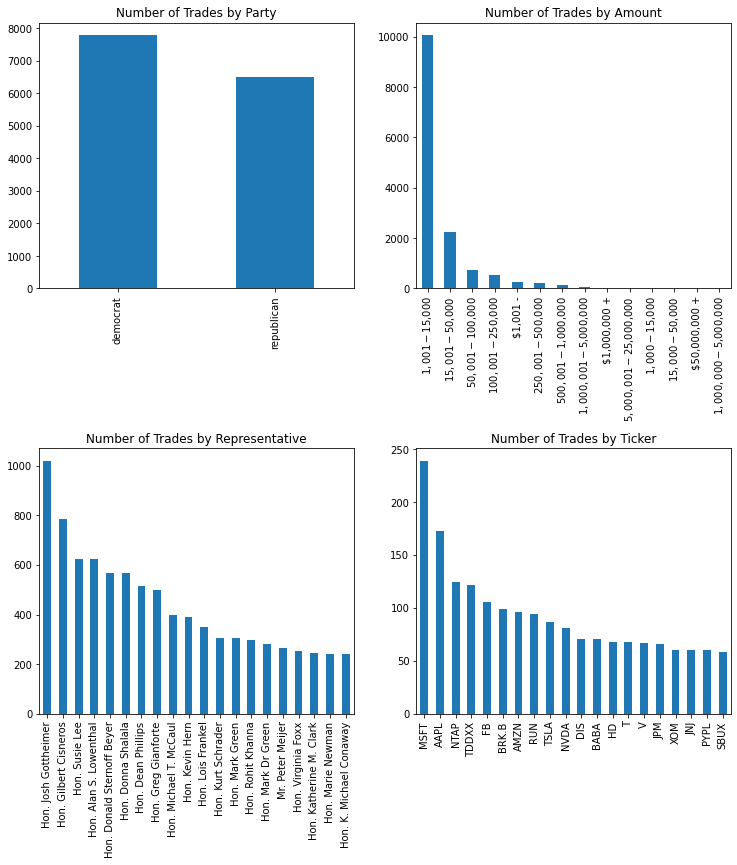

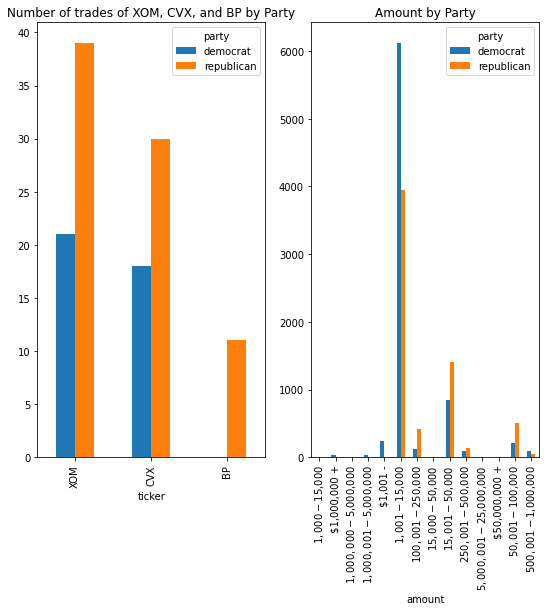

In [519]:
transactions = pd.read_csv('data/all_transactions.csv')
house = pd.read_csv('data/us-house.csv')[['state_code','district','party']]

#owner: '--' to np.NaN
transactions['owner'] = transactions['owner'].replace('--',np.NaN)
#ticker: '--' to np.NaN
transactions['ticker'] = transactions['ticker'].replace('--',np.NaN)

#disclosure_date to datestamp
transactions['disclosure_date'] = pd.to_datetime(transactions['disclosure_date'])

#Some of the transaction dates were incorrect and were causing errors when converting them to datetime so I had to go to the disclosure pdfs and correct them.
#2314 0009-06-09 to 2021-07-06
transactions['transaction_date'].replace('0009-06-09','2021-07-06', inplace=True)
#4024 0021-08-02 to 2021-08-02
transactions['transaction_date'].replace('0021-08-02','2021-08-02', inplace=True)
#7599 20221-11-18 to 2021-11-18
transactions['transaction_date'].replace('20221-11-18','2021-11-18', inplace=True)
#10754 0021-06-22 to 2021-06-22
transactions['transaction_date'].replace('0021-06-22','2021-06-22', inplace=True)
#10755 0201-06-22 to 2021-06-22
transactions['transaction_date'].replace('0201-06-22','2021-06-22', inplace=True)

#transaction_date to datestamp
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'].str.split('-').apply(lambda x : '/'.join([x[1],x[2],x[0]])))

#adding members' current party to transactions dataframe
names = transactions['representative']

#replace NaNs in district column to 0 to corrospond to naming methods used in transaction dataset 
house['district'] = house['district'].replace(np.NaN,0).astype('int64').astype('str')
house['district'] = house['district'].apply(lambda x : x.rjust(2, '0'))
district_code = house['state_code'] + house['district']
house['district_code'] = district_code
house = house[['district_code','party']]

#House dataset I used did not have an entry for the Representative from DC so I had to add it myself
house = pd.concat([house,pd.DataFrame({'district_code':'DC00','party':'democrat'}, index = [435])])
transactions = transactions.merge(house, 'left', left_on='district', right_on='district_code').drop('district_code', axis = 1)

#Univariate Analysis
univariate, u_axes = plt.subplots(nrows=2, ncols=2)
univariate.set_figheight(12)
univariate.set_figwidth(12)
#Plot of number of trades by party
transactions['party'].value_counts().plot.bar(ax = u_axes[0,0])
#Plot of number of trades by amount
transactions['amount'].value_counts().plot.bar(ax = u_axes[0,1])
#Plot of number of trades by representative
transactions['representative'].value_counts()[:20].plot.bar(ax = u_axes[1,0])
#Plot number of trades by ticker
transactions['ticker'].value_counts()[:20].plot.bar(ax = u_axes[1,1])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.6)

u_axes[0,0].set_title('Number of Trades by Party')
u_axes[0,1].set_title('Number of Trades by Amount')
u_axes[1,0].set_title('Number of Trades by Representative')
u_axes[1,1].set_title('Number of Trades by Ticker')


#Bivariate Analysis
bivariate, b_axes = plt.subplots(nrows=1,ncols=2)
bivariate.set_figheight(8)
bivariate.set_figwidth(9)

#Party and ticker
p_t = transactions[['party','ticker']]
p_t_pivot = p_t.pivot_table(index='ticker',columns='party',aggfunc='size')
p_t_pivot = p_t_pivot.replace(np.NaN,0)
p_t_pivot.loc[['XOM','CVX','BP']].plot.bar(ax = b_axes[0])
b_axes[0].set_title('Number of trades of XOM, CVX, and BP by Party')
#Party and amount
p_a = transactions[['party','amount']]
p_a_pivot = p_a.pivot_table(index='amount',columns='party',aggfunc='size')
p_a_pivot = p_a_pivot.replace(np.NaN,0)

p_a_pivot.plot.bar(ax = b_axes[1])
b_axes[1].set_title('Amount by Party')

transactions.pivot_table(index='ticker',columns='party',aggfunc='size').fillna(0)

### Assessment of Missingness

The following code block uses ks_2samp from scipy in order to determine which columns the 'owner' columns depends on in terms of randomness.

In [451]:
#Using scipy package to run KS 2 sample tests on columns
missing = transactions.copy()
missing['owner_missing'] = missing['owner'].isna()

#Calculate KS stat for represenative column
two_col = missing[['representative', 'owner_missing']].pivot_table(index = 'representative', columns='owner_missing', aggfunc='size').fillna(0)
print('representative:',stats.ks_2samp(two_col.iloc[:,0],two_col.iloc[:,1]).pvalue)

#Calculate KS stat for district column
two_col = missing[['district', 'owner_missing']].pivot_table(index = 'district', columns='owner_missing', aggfunc='size').fillna(0)
print('disrict:',stats.ks_2samp(two_col.iloc[:,0],two_col.iloc[:,1]).pvalue)

#Calculate KS stat for district column
two_col = missing[['ptr_link', 'owner_missing']].pivot_table(index = 'ptr_link', columns='owner_missing', aggfunc='size').fillna(0)
print('ptr_link:',stats.ks_2samp(two_col.iloc[:,0],two_col.iloc[:,1]).pvalue)

representative: 0.00023711109374995574
disrict: 0.0003094687303280408
ptr_link: 0.00036272674011688104


### Hypothesis Testing

The following code block conducts a permuation test with 1000 repetitions with TVD as the test statistic in order to determine whether or not the null hypothesis needs to be rejected.

0.0


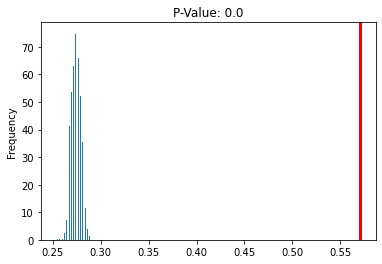

In [515]:
#Null Hypothesis:
#The distribution of number of trades by ticker among Republicans is the same as those who are Democrats. The difference between the two observed samples is due to chance.
#Alternative Hypothesis
#The distribution of number of trades by ticker of these two groups is different.
#selecting only needed columns
ht_df = transactions[['ticker','party']].reset_index().drop('index',axis=1)

tick_counts = ht_df.pivot_table(index='ticker',columns='party', aggfunc='size').fillna(0)
cond_distr = tick_counts/tick_counts.sum()

obs_tvd = cond_distr.diff(axis=1).iloc[:,-1].abs().sum()/2

def tvd_of_groups(df):
    cnts = df.pivot_table(index = 'ticker', columns='party', aggfunc = 'size').fillna(0)
    distr = cnts / cnts.sum()
    return distr.diff(axis=1).iloc[:, -1].abs().sum() / 2

tvds = []

n_reps = 1000

for i in range(n_reps):
    s = ht_df['party'].sample(frac=1).reset_index(drop=True)
    
    shuffled = ht_df.loc[:,['ticker']].assign(party=s)
    
    tvds.append(tvd_of_groups(shuffled))
    
tvds = pd.Series(tvds)

p_val = (tvds >= obs_tvd).sum() / n_reps

tvds.plot(kind = 'hist', density = True, ec='w', bins = 20, title = f'P-Value: {p_val}',label='Simulated TVDS')
plt.axvline(x=obs_tvd, color = 'red', linewidth = 3, label = 'P-Value')
print(p_val)